In [ ]:
!pip install tensorflow tensorflow_federated matplotlib numpy

  Using cached jaxlib-0.4.14-cp311-cp311-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached jax-0.4.14-py3-none-any.whl
  Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached jaxlib-0.4.14-cp311-cp311-manylinux2014_x86_64.whl (73.7 MB)
Using cached scipy-1.9.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.4 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.3
    Uninstalling jaxlib-0.5.3:
      Successfully uninstalled jaxlib-0.5.3
  Attempting uninstall: jax
    Found existing installation: jax 0.5.3
    Uninstalling jax-0.5.3:
      Successfully uninstalled jax-0.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [ ]:
!pip install --upgrade jax jaxlib
!pip install triton

  Using cached jax-0.5.3-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (21 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached jax-0.5.3-py3-none-any.whl (2.4 MB)
Using cached jaxlib-0.5.3-cp311-cp311-manylinux2014_x86_64.whl (105.1 MB)
Using cached ml_dtypes-0.5.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
  Attempting uninstall: scipy
    Found existing installation: scipy 1.9.3
    Uninstalling scipy-1.9.3:
      Successfully uninstalled scipy-1.9.3
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninsta

In [ ]:
!pip install tensorflow

  Using cached ml_dtypes-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached ml_dtypes-0.2.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.3 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.14.1 which is incompatible.
tensorstore 0.1.73 requires ml_dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.


/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.1 is installed, but it is not compatible with the installed jaxlib version 0.5.3, so it will not be used.
  warnings.warn(


170498071/170498071 [==============================] - 13s 0us/step
Round 1, Train Accuracy: 0.1563
Round 2, Train Accuracy: 0.2284
Round 3, Train Accuracy: 0.2774
Round 4, Train Accuracy: 0.3149
Round 5, Train Accuracy: 0.3514


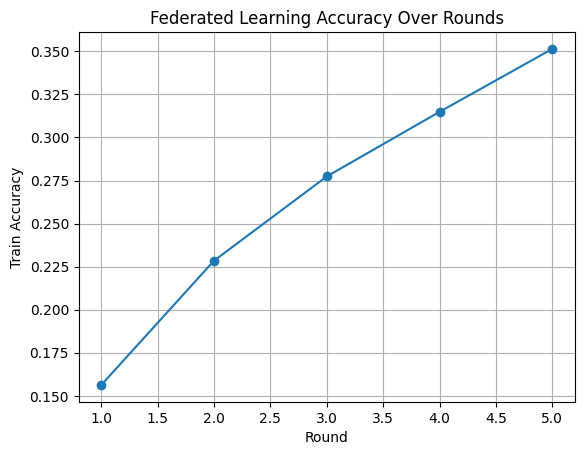

In [ ]:
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import matplotlib.pyplot as plt

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert labels to int32 and flatten
y_train = y_train.flatten().astype(np.int32)
y_test = y_test.flatten().astype(np.int32)

# Convert to float32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Create federated data
def create_federated_data(x, y, num_clients=10):
    client_data = []
    data_per_client = len(x) // num_clients
    for i in range(num_clients):
        start = i * data_per_client
        end = (i + 1) * data_per_client
        dataset = tf.data.Dataset.from_tensor_slices((x[start:end], y[start:end]))
        dataset = dataset.shuffle(1000).batch(32)
        client_data.append(dataset)
    return client_data

NUM_CLIENTS = 10
federated_train_data = create_federated_data(x_train, y_train, NUM_CLIENTS)

# Define Keras model
def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

# Model function for TFF
def model_fn():
    keras_model = create_keras_model()
    input_spec = federated_train_data[0].element_spec
    return tff.learning.models.from_keras_model(
        keras_model=keras_model,
        input_spec=input_spec,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )

# Federated averaging algorithm
iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

# Initialize training
state = iterative_process.initialize()

# Training loop
NUM_ROUNDS = 5
accuracy_list = []

for round_num in range(1, NUM_ROUNDS + 1):
    result = iterative_process.next(state, federated_train_data)
    state = result.state
    metrics = result.metrics

    # Directly extract from the known structure
    accuracy = metrics['client_work']['train']['sparse_categorical_accuracy']
    accuracy_list.append(accuracy)

    print(f'Round {round_num}, Train Accuracy: {accuracy:.4f}')


# Plot accuracy curve
plt.plot(range(1, NUM_ROUNDS + 1), accuracy_list, marker='o')
plt.xlabel('Round')
plt.ylabel('Train Accuracy')
plt.title('Federated Learning Accuracy Over Rounds')
plt.grid(True)
plt.show()
